# Riconoscimento vocale

In [1]:
import os
from time import time

import numpy as np
import pandas as pd
from tabulate import tabulate

from scipy.io import wavfile as wav
from scipy.fftpack import rfft, fft, fftfreq

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import scale

import librosa
from librosa.core import istft

from joblib import dump, load

import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd

<font size=3>
    
I file caricati sono delle registrazioni di date effettuate dai due componenti del gruppo.<br></br>
Dal nome del file vengono estratte le informazioni riguardanti la classe che sarà utilizzata per il task di classificazione. Gli elementi di interesse sono divisi da un underscore e sono rappresentati da:
* Codice identificativo della persona che parla (0:Luca, 1:Matteo)
* Giorno pronunciato
* Mese pronunciato
<br></br>

Nella funzione <b>load_data</b> sono presenti i seguenti parametri:
* <i>feature_extractor</i>: il metodo per estrarre le features dall'audio
* <i>ext</i>: l'estensione dei file da leggere, nel nostro caso file loseless .wav
* <i>normalize</i>: parametro che indica se effettuare o meno una normalizzazione delle features
* <i>classify</i>: valore numerico che indica quale oggetto prendere come target per la classificazione.
<br></br>

Il parametro <i>classify</i> governa lo split utile per ottenere il target richiesto. I possibili target di classificazione (valori passabili a classify) sono:

* <b>0</b>: persona che parla
* <b>1</b>: mese
* <b>2</b>: giorno + mese
* <b>3</b>: persona che parla + mese
* <b>4</b>: presona che parla + giorno + mese
<br></br>

Una volta scelto il target, si procede alla divisione del set in train e test, con dimensione del test uguale a 0.2.

In [2]:
def load_data(feature_extractor, ext, normalize=True, classify=0):
    labels = []
    features = []

    for f in sorted(os.listdir('./records')):
        if f.endswith(ext):
            _, signal = wav.read('./records/' + f) # Sampling rate e numpy array con il segnale
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Categorie
            if classify == 0:
                label = f.split('_')[classify]
                if label == str(0):
                    label = "Luca"
                else:
                    label = "Matteo"
                    
            elif classify == 1:
                label = f.split('_')[classify + 1]
            elif classify == 2:
                target = f.split('_')
                label = target[1] + ' ' + target[2]
            elif classify == 3:
                target = f.split('_')
                if target[0] == str(0):
                    target[0] = "Luca"
                else:
                    target[0] = "Matteo"
                label = target[0] + ' ' + target[2]
            elif classify == 4:
                target = f.split('_')
                if target[0] == str(0):
                    target[0] = "Luca"
                else:
                    target[0] = "Matteo"
                label = target[0] + ' ' +  target[1] + ' ' + target[2]
            else:
                print('Valore di classify in input non regolare, deve essere compreso fra 0-4')
                break
            
            labels.append(label)

    # Separazione training / test set
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1, stratify=labels)

    # Normalizza ciascuna dimensione delle feature
    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test, X_train_mean, X_train_std

<font size=3>

La funzione utilizzata per estrarre le feature dei segnali audio è ``mfcc``, che sta per <i> Mel frequency cepstrum coefficients </i>.<br> Il cepstrum è, in sostanza, un'informazione relativa al tasso di cambiamento di bande spettrali di un segnale. <br>
In input viene passato il file .wav letto in precedenza che diventa il primo elemento della funzione ``librosa.feature.mfcc``. Si campiona un valore ogni tot in modo da avere un input più leggero, privo di informazione ridondante. <br> 
Con la funzione ``mfcc`` vengono ricavati i coefficienti partendo dal segnale e dalla frequenza di campionamento del segnale originale. <br></br>
Si normalizza infine la lunghezza della rappresentazione utilizzando come upper bound un valore in input che dovrà essere maggiore della massima lunghezza dei valori mfcc trovati. <br>

In [3]:
def mfcc(input, rate, min_len, sample):
    signal = input[::sample]
    signal = signal.flatten()
    mfcc = librosa.feature.mfcc(signal*1.0, sr=rate) 
    pad_width = min_len - mfcc.shape[1] 
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc.flatten()

<font size=3>
    
La seguente funzione definisce una nuova colormap che sarà utilizzata successivamente per la matrice di classificazione. La  rappresentazione grafica verrà fatta sui valori in percentuale e non su quelli totali.

In [4]:
def matrix(prediction, tests, names):
    # New colormap
    norm = matplotlib.colors.Normalize(-1,1)
    colors = [[norm(-1.0), "lightyellow"],
              [norm(-0.95), "antiquewhite"],
              [norm(-0.8), "wheat"],
              [norm(-0.3), "navajowhite"],
              [norm( 0.3), "orange"],
              [norm( 0.8), "tomato"],
              [norm( 0.9), "red"],
              [norm( 1.0), "darkred"]]

    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
    
    print(classification_report(tests, prediction)) 
    
    print("Accuracy: " + str(round(accuracy_score(tests, prediction), 3)) + "\n")
    cm = confusion_matrix(tests, prediction)
    print(cm)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Trasforma i valori in percentuale
    
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=cmap)
    fig.colorbar(cax)

    plt.title('Confusion matrix', pad=40)
    
    # Viene forzata la visualizzazione di tutte le label
    ax.set_xticks(np.arange(len(names)))
    ax.set_yticks(np.arange(len(names)))
    
    ax.set_xticklabels(names, rotation=35) # I nomi sull'asse x saranno ruotati
    ax.set_yticklabels(names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Componenti del gruppo

<font size=3>
    
Il primo task di classificazione è quello di riconoscere l'identità di chi parla indipendentemente da cosa viene detto.

In [5]:
# Caricamento dati
X_train, X_test, y_train, y_test, x_train_mean, x_train_std = load_data(feature_extractor=lambda x: mfcc(x, 
                                                                                                         rate=44100, 
                                                                                                         min_len=300, 
                                                                                                         sample=5),
                                                                        ext=".wav", classify=0)

<font size=3>
    
I modelli migliori sono stati salvati attraverso un dump e sono caricati in questa linea di codice che precede la grid search. Sono stati salvati tutti i modelli per ogni task classificativo.

In [6]:
clf0 = load('SVC0.joblib')

In [7]:
# Parametri da provare in cross validation
param_grid = {'C': [0.01, 0.05, 0.1],
              'gamma': [0.1, 0.5, 1, 2]}

# Inizializzazione Support Vector Machine
clf0 = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Addestramento
t0 = time()
clf_a = clf0.fit(X_train, y_train)
print("Addestramento completato in %0.3fs" % (time() - t0))

# Risultato della cross validation
print("Migliore combinazione di parametri:")
print(" C: " + str(clf0.best_estimator_.C))
print(" gamma: " + str(clf0.best_estimator_.gamma))

Addestramento completato in 117.801s
Migliore combinazione di parametri:
 C: 0.1
 gamma: 0.5


              precision    recall  f1-score   support

        Luca       0.99      0.96      0.97        96
      Matteo       0.96      0.99      0.97        96

   micro avg       0.97      0.97      0.97       192
   macro avg       0.97      0.97      0.97       192
weighted avg       0.97      0.97      0.97       192

Accuracy: 0.974

[[92  4]
 [ 1 95]]


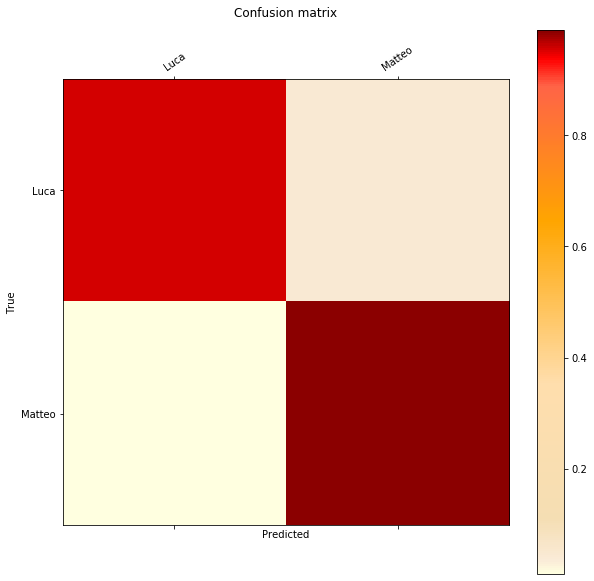

In [8]:
y_pred = clf_a.predict(X_test)

matrix(prediction=y_pred, tests=y_test, names=list(np.unique(y_train)))

In [9]:
dump(clf0, 'SVC0.joblib')

['SVC0.joblib']

## Mesi

<font size=3>
    
Utilizzando sempre SVC si effettua il secondo task di classificazione per identificare il mese che viene pronunciato. <br>
In questo caso il campionamento ogni $5$ valori risulta migliore di quello ogni $3$. I parametri per la grid search sono notevolmente diversi rispetto al task precedente in quanto mantenendo fissi quei valori si ottenevano delle pessime performance.

In [10]:
# Caricamento dati
X_train, X_test, y_train, y_test, x_mean, x_std = load_data(feature_extractor=lambda x: mfcc(x, 
                                                                                             rate=44100, 
                                                                                             min_len=300, 
                                                                                             sample=5),
                                             ext=".wav", classify=1)

In [11]:
clf1 = load('SVC1.joblib') 

In [12]:
# Parametri da provare in cross validation
param_grid = {'C': [1000, 750, 500],
              'gamma': [0.0001, 0.0005]}

# Inizializzazione Support Vector Machine
clf1 = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=3, verbose=3)

# Addestramento
t0 = time()
clf1 = clf1.fit(X_train, y_train)
print("Addestramento completato in %0.3fs" % (time() - t0))

# Risultato della cross validation
print("Migliore combinazione di parametri:")
print(" C: " + str(clf1.best_estimator_.C))
print(" gamma: " + str(clf1.best_estimator_.gamma))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] C=1000, gamma=0.0001 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... C=1000, gamma=0.0001, score=0.6704545454545454, total=   6.6s
[CV] C=1000, gamma=0.0001 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s remaining:    0.0s


[CV] ... C=1000, gamma=0.0001, score=0.5952380952380952, total=   6.8s
[CV] C=1000, gamma=0.0001 ............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.1s remaining:    0.0s


[CV] ... C=1000, gamma=0.0001, score=0.6785714285714286, total=   6.8s
[CV] C=1000, gamma=0.0005 ............................................
[CV] ... C=1000, gamma=0.0005, score=0.6666666666666666, total=   7.1s
[CV] C=1000, gamma=0.0005 ............................................
[CV] ... C=1000, gamma=0.0005, score=0.6150793650793651, total=   6.7s
[CV] C=1000, gamma=0.0005 ............................................
[CV] ... C=1000, gamma=0.0005, score=0.7023809523809523, total=   7.4s
[CV] C=750, gamma=0.0001 .............................................
[CV] .... C=750, gamma=0.0001, score=0.6704545454545454, total=   6.4s
[CV] C=750, gamma=0.0001 .............................................
[CV] .... C=750, gamma=0.0001, score=0.5952380952380952, total=   6.1s
[CV] C=750, gamma=0.0001 .............................................
[CV] .... C=750, gamma=0.0001, score=0.6785714285714286, total=   6.8s
[CV] C=750, gamma=0.0005 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  2.9min finished
c:\users\prowm\anaconda3\envs\dsim\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Addestramento completato in 187.286s
Migliore combinazione di parametri:
 C: 1000
 gamma: 0.0005


              precision    recall  f1-score   support

      Agosto       1.00      0.75      0.86        16
      Aprile       0.88      0.88      0.88        16
    Dicembre       0.55      1.00      0.71        16
    Febbraio       0.67      0.88      0.76        16
     Gennaio       0.75      0.75      0.75        16
      Giugno       0.78      0.88      0.82        16
      Luglio       0.78      0.44      0.56        16
      Maggio       0.93      0.81      0.87        16
       Marzo       0.78      0.88      0.82        16
    Novembre       1.00      0.56      0.72        16
     Ottobre       0.82      0.88      0.85        16
   Settembre       0.77      0.62      0.69        16

   micro avg       0.78      0.78      0.78       192
   macro avg       0.81      0.78      0.77       192
weighted avg       0.81      0.78      0.77       192

Accuracy: 0.776

[[12  0  0  0  0  0  0  0  2  0  1  1]
 [ 0 14  0  2  0  0  0  0  0  0  0  0]
 [ 0  0 16  0  0  0  0  0  0  0  0  0]

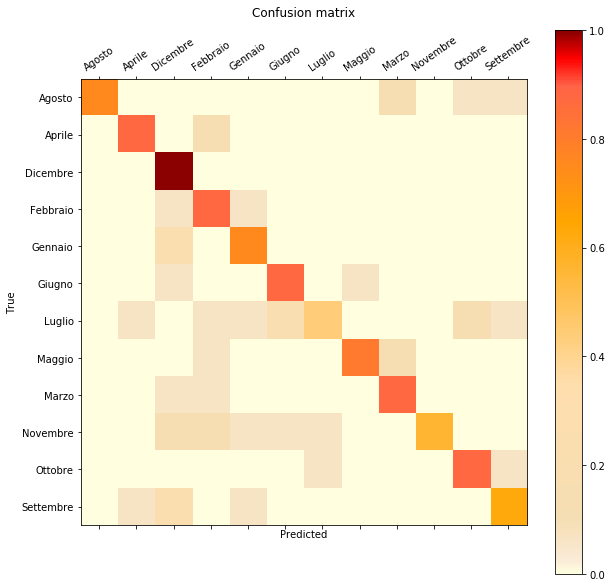

In [13]:
y_pred = clf1.predict(X_test)

matrix(prediction=y_pred, tests=y_test, names=list(np.unique(y_train)))

In [14]:
dump(clf1, 'SVC1.joblib')

['SVC1.joblib']

## Giorno + mese

<font size=3>
    
Come terzo task si cercherà di identifica il giorno e il mese dell'audio.

In [15]:
# Caricamento dati
X_train, X_test, y_train, y_test, x_mean, x_std  = load_data(feature_extractor=lambda x: mfcc(x, 
                                                                                              rate=44100, 
                                                                                              min_len=300, 
                                                                                              sample=5),
                                                             ext=".wav", classify=2)

In [16]:
clf2 = load('SVC2.joblib') 

In [18]:
# Parametri da provare in cross validation
param_grid = {'C': [1000, 750, 500, 200, 10],
              'gamma': [0.0001, 0.0005, 0.001, 0.005]}

# Inizializzazione Support Vector Machine
clf2 = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=3, verbose=3,
                    n_jobs=2)

# Addestramento
t0 = time()
clf2 = clf2.fit(X_train, y_train)
print("Addestramento completato in %0.3fs" % (time() - t0))

# Risultato della cross validation
print("Migliore combinazione di parametri:")
print(" C: " + str(clf2.best_estimator_.C))
print(" gamma: " + str(clf2.best_estimator_.gamma))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:  6.3min finished
c:\users\prowm\anaconda3\envs\dsim\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Addestramento completato in 389.534s
Migliore combinazione di parametri:
 C: 1000
 gamma: 0.0001


In [19]:
dump(clf2, 'SVC2.joblib')

['SVC2.joblib']

              precision    recall  f1-score   support

    1 Agosto       0.60      0.75      0.67         8
    1 Aprile       0.50      0.50      0.50         8
  1 Dicembre       0.33      0.62      0.43         8
  1 Febbraio       0.40      0.50      0.44         8
   1 Gennaio       0.88      0.88      0.88         8
    1 Giugno       0.43      0.38      0.40         8
    1 Luglio       0.50      0.38      0.43         8
    1 Maggio       0.80      0.50      0.62         8
     1 Marzo       0.42      0.62      0.50         8
  1 Novembre       0.67      0.50      0.57         8
   1 Ottobre       0.67      0.75      0.71         8
 1 Settembre       0.60      0.38      0.46         8
    2 Agosto       0.67      0.75      0.71         8
    2 Aprile       0.71      0.62      0.67         8
  2 Dicembre       0.67      0.50      0.57         8
  2 Febbraio       0.75      0.75      0.75         8
   2 Gennaio       0.86      0.75      0.80         8
    2 Giugno       0.67    

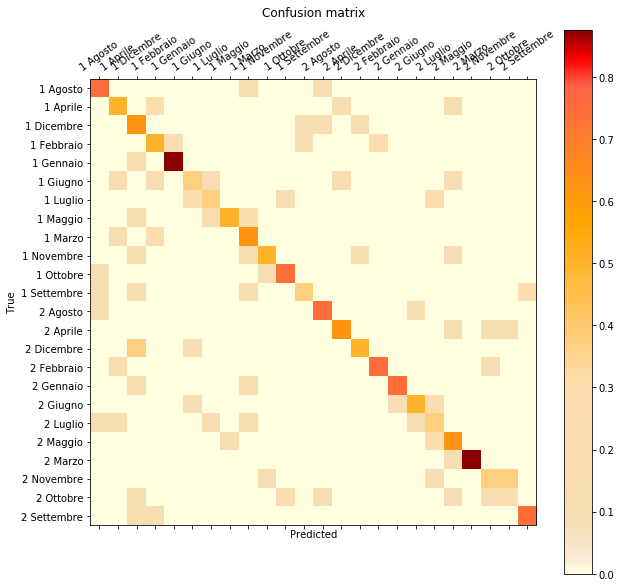

In [20]:
y_pred = clf2.predict(X_test)

matrix(prediction=y_pred, tests=y_test, names=list(np.unique(y_train)))

## Persona + mese

<font size=3>

Penultimo task di classificazione con persona e mese

In [21]:
# Caricamento dati
X_train, X_test, y_train, y_test, x_mean, x_std  = load_data(feature_extractor=lambda x: mfcc(x, 
                                                                                              rate=44100, 
                                                                                              min_len=300, 
                                                                                              sample=5),
                                                             ext=".wav", classify=3)

In [ ]:
clf3 = load('SVC3.joblib') 

In [22]:
# Parametri da provare in cross validation
param_grid = {'C': [10, 200, 500, 1000],
              'gamma': [0.0001, 0.0005, 0.001, 0.005]}

# Inizializzazione Support Vector Machine
clf3 = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=3, verbose=3, n_jobs=2)

# Addestramento
t0 = time()
clf3 = clf3.fit(X_train, y_train)
print("Addestramento completato in %0.3fs" % (time() - t0))

# Risultato della cross validation
print("Migliore combinazione di parametri:")
print(" C: " + str(clf3.best_estimator_.C))
print(" gamma: " + str(clf3.best_estimator_.gamma))

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:  6.0min finished
c:\users\prowm\anaconda3\envs\dsim\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Addestramento completato in 371.233s
Migliore combinazione di parametri:
 C: 200
 gamma: 0.0001


                  precision    recall  f1-score   support

     Luca Agosto       0.80      1.00      0.89         8
     Luca Aprile       0.43      0.38      0.40         8
   Luca Dicembre       0.78      0.88      0.82         8
   Luca Febbraio       0.89      1.00      0.94         8
    Luca Gennaio       0.75      0.38      0.50         8
     Luca Giugno       0.83      0.62      0.71         8
     Luca Luglio       0.80      0.50      0.62         8
     Luca Maggio       0.64      0.88      0.74         8
      Luca Marzo       0.80      1.00      0.89         8
   Luca Novembre       0.64      0.88      0.74         8
    Luca Ottobre       1.00      0.62      0.77         8
  Luca Settembre       0.71      0.62      0.67         8
   Matteo Agosto       1.00      0.75      0.86         8
   Matteo Aprile       1.00      0.62      0.77         8
 Matteo Dicembre       0.54      0.88      0.67         8
 Matteo Febbraio       0.89      1.00      0.94         8
  Matteo Genn

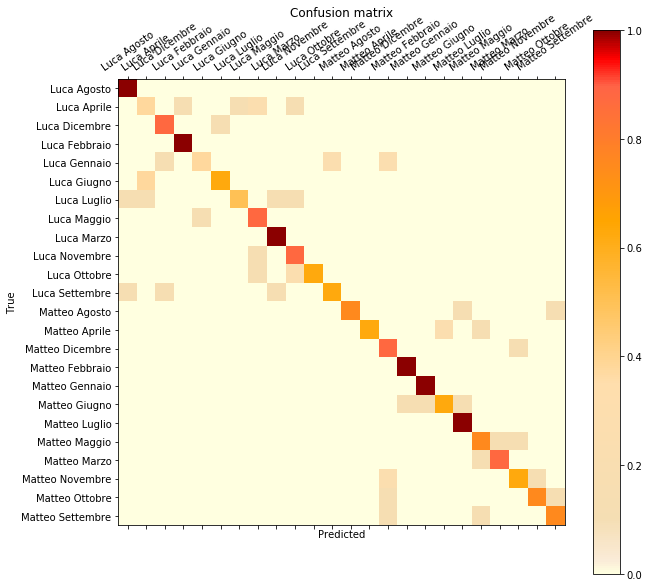

In [23]:
y_pred = clf3.predict(X_test)

matrix(prediction=y_pred, tests=y_test, names=list(np.unique(y_train)))

In [24]:
dump(clf3, 'SVC3.joblib')

['SVC3.joblib']

## Persona + giorno + mese

<font size=3>
    
Ultimo task di classificazione, e il più complicato, in cui l'algoritmo cercherò di identifica la persona e cosa viene detto.

In [25]:
# Caricamento dati
X_train, X_test, y_train, y_test, x_mean, x_std  = load_data(feature_extractor=lambda x: mfcc(x, 
                                                                                              rate=44100, 
                                                                                              min_len=300, 
                                                                                              sample=5),
                                                             ext=".wav", classify=4)

In [ ]:
clf4 = load('SVC4.joblib') 

In [26]:
# Parametri da provare in cross validation
param_grid = {'C': [10, 200, 500, 1000],
              'gamma': [0.0001, 0.0005, 0.001, 0.005]}

# Inizializzazione Support Vector Machine
clf4 = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=3, verbose=3, n_jobs=1)

# Addestramento
t0 = time()
clf4 = clf4.fit(X_train, y_train)
print("Addestramento completato in %0.3fs" % (time() - t0))

# Risultato della cross validation
print("Migliore combinazione di parametri:")
print(" C: " + str(clf4.best_estimator_.C))
print(" gamma: " + str(clf4.best_estimator_.gamma))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] C=10, gamma=0.0001 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... C=10, gamma=0.0001, score=0.5555555555555556, total=  10.0s
[CV] C=10, gamma=0.0001 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.2s remaining:    0.0s


[CV] ................... C=10, gamma=0.0001, score=0.55, total=   9.4s
[CV] C=10, gamma=0.0001 ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.3s remaining:    0.0s


[CV] ................... C=10, gamma=0.0001, score=0.55, total=   9.6s
[CV] C=10, gamma=0.0005 ..............................................
[CV] ..... C=10, gamma=0.0005, score=0.5243055555555556, total=   7.9s
[CV] C=10, gamma=0.0005 ..............................................
[CV] ................. C=10, gamma=0.0005, score=0.5625, total=   9.1s
[CV] C=10, gamma=0.0005 ..............................................
[CV] ..... C=10, gamma=0.0005, score=0.5916666666666667, total=   9.1s
[CV] C=10, gamma=0.001 ...............................................
[CV] ...... C=10, gamma=0.001, score=0.4965277777777778, total=   7.0s
[CV] C=10, gamma=0.001 ...............................................
[CV] .................. C=10, gamma=0.001, score=0.5375, total=   8.5s
[CV] C=10, gamma=0.001 ...............................................
[CV] ...... C=10, gamma=0.001, score=0.5666666666666667, total=   7.3s
[CV] C=10, gamma=0.005 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  9.4min finished
c:\users\prowm\anaconda3\envs\dsim\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Addestramento completato in 575.659s
Migliore combinazione di parametri:
 C: 200
 gamma: 0.0001


                    precision    recall  f1-score   support

     Luca 1 Agosto       1.00      0.75      0.86         4
     Luca 1 Aprile       0.25      0.75      0.38         4
   Luca 1 Dicembre       0.50      0.75      0.60         4
   Luca 1 Febbraio       0.67      0.50      0.57         4
    Luca 1 Gennaio       0.67      0.50      0.57         4
     Luca 1 Giugno       0.33      0.25      0.29         4
     Luca 1 Luglio       0.33      0.25      0.29         4
     Luca 1 Maggio       1.00      0.75      0.86         4
      Luca 1 Marzo       0.33      0.50      0.40         4
   Luca 1 Novembre       0.60      0.75      0.67         4
    Luca 1 Ottobre       1.00      0.25      0.40         4
  Luca 1 Settembre       0.67      0.50      0.57         4
     Luca 2 Agosto       1.00      0.75      0.86         4
     Luca 2 Aprile       0.67      0.50      0.57         4
   Luca 2 Dicembre       0.60      0.75      0.67         4
   Luca 2 Febbraio       1.00      0.50

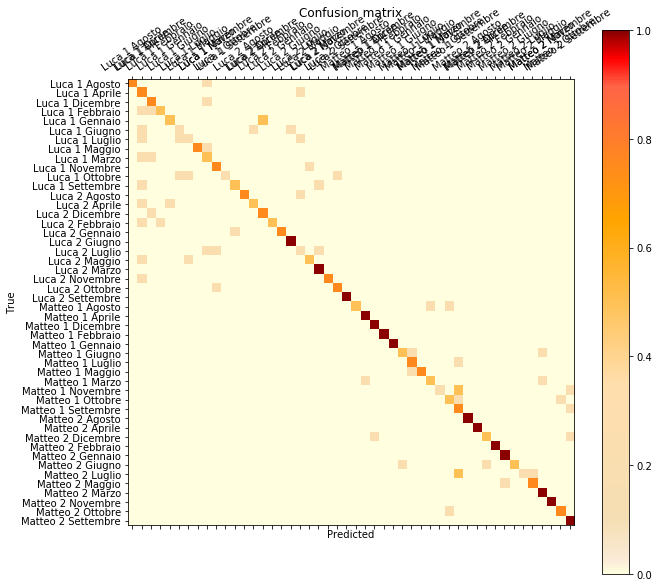

In [27]:
y_pred = clf4.predict(X_test)

matrix(prediction=y_pred, tests=y_test, names=list(np.unique(y_train)))

In [28]:
dump(clf4, 'SVC4.joblib')

['SVC4.joblib']

# Esempio di riproduzione audio e classificazione

In [29]:
def load_audio(feature_extractor, ext, file_name, classify=0):
    labels = []
    features = []

    _, signal = wav.read('./records/' + file_name) # Sampling rate e numpy array con il segnale
    cur_features = feature_extractor(signal)
    features.append(cur_features)

    # Categorie
    if classify == 0:
        label = file_name.split('_')[classify]
        if label == str(0):
            label = "Luca"
        else:
            label = "Matteo"
                    
    elif classify == 1:
        label = f.split('_')[classify + 1]
    elif classify == 2:
        target = f.split('_')
        label = target[1] + target[2]
    elif classify == 3:
        target = f.split('_')
        if target[0] == str(0):
            target[0] = "Luca"
        else:
            target[0] = "Matteo"
        label = target[0] + target[2]
    elif classify == 4:
        target = f.split('_')
        if target[0] == str(0):
            target[0] = "Luca"
        else:
            target[0] = "Matteo"
        label = target[0] + target[1] + target[2]
    else:
        print('Valore di classify in input non regolare, deve essere compreso fra 0-4')
            
    labels.append(label)

    return features, signal

In [32]:
eps = 0.001
_,_,_,_, X_train_mean, X_train_std = load_data(feature_extractor=lambda x: mfcc(x, rate=44100, min_len=300, sample=5),
                                               ext=".wav", classify=0)

name = "1_1_Marzo_7.wav"
if name[0]=='0':
    print('Segnale audio registrato da: Luca' + '\n')
else:
    print('Segnale audio registrato da: Matteo' + '\n')
    
feat, signal = load_audio(feature_extractor=lambda x: mfcc(x, rate=44100, min_len=300, sample=5), 
                          ext=".wav", file_name=name, classify=0)

#_, signal = wav.read('./records/' + name)
audio = signal[:,0]

cur_features = (feat)
cur_features2 = (cur_features - X_train_mean + eps)/(X_train_std + eps)

#print(cur_features2)

#clf = SVC(kernel='rbf', C=clf.best_estimator_.C, gamma=clf.best_estimator_.gamma, probability=True)
#clf.fit(X_train, y_train)
pred = clf0.predict(cur_features2.reshape(1,-1))
if pred == '0':
    print('La voce è di: Luca')
else:
    print('La voce è di: Matteo')
    
ipd.Audio(audio, rate=44100)  

Segnale audio registrato da: Matteo

La voce è di: Matteo
